In [1]:
import json
import numpy as np
from rouge import Rouge
from sklearn.utils import resample
import matplotlib.pyplot as plt
import re


In [2]:
# Load ground truth data from a JSON file
with open('data/ground_truth.json', 'r') as f:
    records = json.load(f)

In [3]:
records

[{'filename': 'Ryan Case 2.txt',
  'language': 'english',
  'transcription': "Speaker Guest-1: Hello. Hi, Doctor Way. Hi there. It's nice to meet you. Nice to meet you too. How can I help?\nSpeaker Guest-2: You today I'm looking for a prescription refill for two of my medications.\nSpeaker Guest-1: OK. Sounds good. I'm certainly happy to help with that. If you could just let me know the names of your two medications as well as the dosages you take that.\nSpeaker Guest-2: Yep. So the first one is Ramipril and I take 10 milligrams.\nSpeaker Guest-2: Daily. Mm-hmm. And then the second one that I'm looking for is Crestor. And again, that's 10 milligrams daily.\nSpeaker Guest-1: OK. Sounds good. And I'm guessing the ramipril you take it for blood pressure management and then the Crestor you take it for cholesterol?\nSpeaker Guest-2: Yes, that's right.\nSpeaker Guest-1: Sounds good, and roughly how long have you been taking these medications for?\nSpeaker Guest-2: Both for five years.\nSpeak

In [8]:
def compute_bootstrap_confidence_intervals_per_section(records, n_samples=1000, ci=0.95):
    rouge = Rouge()
    sections = ['Subjective', 'Objective', 'Assessment', 'Plan']
    scores = {section: {'rouge-1': [], 'rouge-2': [], 'rouge-l': []} for section in sections}

    n = len(records)
    for _ in range(n_samples):
        sample = resample(records, n_samples=n, replace=True)
        for section in sections:
            sample_hyps = []
            sample_refs = []
            for entry in sample:
                hyp = entry['parsed_llm_soap_note'].get(section, '').strip()
                ref = entry['parsed_soap_note'].get(section, '').strip()
                # Only include non-empty hypotheses and references
                if hyp and ref:
                    sample_hyps.append(hyp)
                    sample_refs.append(ref)
            # Check if we have valid pairs before computing ROUGE scores
            if sample_hyps and sample_refs:
                try:
                    score = rouge.get_scores(sample_hyps, sample_refs, avg=True)
                    for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
                        scores[section][metric].append(score[metric]['f'])
                except ValueError as e:
                    print(f"Error computing ROUGE for section '{section}': {e}")
                    pass
            else:
                # No valid pairs to compute ROUGE scores
                pass

    lower_percentile = ((1.0 - ci) / 2.0) * 100
    upper_percentile = (ci + ((1.0 - ci) / 2.0)) * 100
    results = {}
    for section in sections:
        results[section] = {}
        for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
            if scores[section][metric]:
                lower_bound = max(0.0, np.percentile(scores[section][metric], lower_percentile))
                upper_bound = min(1.0, np.percentile(scores[section][metric], upper_percentile))
                results[section][metric] = {
                    'metric': metric.replace('rouge-', 'Rouge-').capitalize(),
                    'lower_bound': round(lower_bound, 4),
                    'upper_bound': round(upper_bound, 4)
                }
            else:
                # If no scores were accumulated for this metric and section
                results[section][metric] = {
                    'metric': metric.replace('rouge-', 'Rouge-').capitalize(),
                    'lower_bound': None,
                    'upper_bound': None
                }
    return results


In [9]:
ci_results = compute_bootstrap_confidence_intervals_per_section(records)

# Output the results as JSON
json_output = json.dumps(ci_results, indent=2)
print(json_output)

{
  "Subjective": {
    "rouge-1": {
      "metric": "Rouge-1",
      "lower_bound": 0.3226,
      "upper_bound": 0.412
    },
    "rouge-2": {
      "metric": "Rouge-2",
      "lower_bound": 0.1089,
      "upper_bound": 0.1593
    },
    "rouge-l": {
      "metric": "Rouge-l",
      "lower_bound": 0.3071,
      "upper_bound": 0.3684
    }
  },
  "Objective": {
    "rouge-1": {
      "metric": "Rouge-1",
      "lower_bound": 0.0,
      "upper_bound": 0.313
    },
    "rouge-2": {
      "metric": "Rouge-2",
      "lower_bound": 0.0,
      "upper_bound": 0.1674
    },
    "rouge-l": {
      "metric": "Rouge-l",
      "lower_bound": 0.0,
      "upper_bound": 0.2957
    }
  },
  "Assessment": {
    "rouge-1": {
      "metric": "Rouge-1",
      "lower_bound": 0.0833,
      "upper_bound": 0.3088
    },
    "rouge-2": {
      "metric": "Rouge-2",
      "lower_bound": 0.0,
      "upper_bound": 0.0536
    },
    "rouge-l": {
      "metric": "Rouge-l",
      "lower_bound": 0.0833,
      "upper_b

In [10]:
ci_results

{'Subjective': {'rouge-1': {'metric': 'Rouge-1',
   'lower_bound': np.float64(0.3226),
   'upper_bound': np.float64(0.412)},
  'rouge-2': {'metric': 'Rouge-2',
   'lower_bound': np.float64(0.1089),
   'upper_bound': np.float64(0.1593)},
  'rouge-l': {'metric': 'Rouge-l',
   'lower_bound': np.float64(0.3071),
   'upper_bound': np.float64(0.3684)}},
 'Objective': {'rouge-1': {'metric': 'Rouge-1',
   'lower_bound': 0.0,
   'upper_bound': np.float64(0.313)},
  'rouge-2': {'metric': 'Rouge-2',
   'lower_bound': 0.0,
   'upper_bound': np.float64(0.1674)},
  'rouge-l': {'metric': 'Rouge-l',
   'lower_bound': 0.0,
   'upper_bound': np.float64(0.2957)}},
 'Assessment': {'rouge-1': {'metric': 'Rouge-1',
   'lower_bound': np.float64(0.0833),
   'upper_bound': np.float64(0.3088)},
  'rouge-2': {'metric': 'Rouge-2',
   'lower_bound': 0.0,
   'upper_bound': np.float64(0.0536)},
  'rouge-l': {'metric': 'Rouge-l',
   'lower_bound': np.float64(0.0833),
   'upper_bound': np.float64(0.2828)}},
 'Plan': {

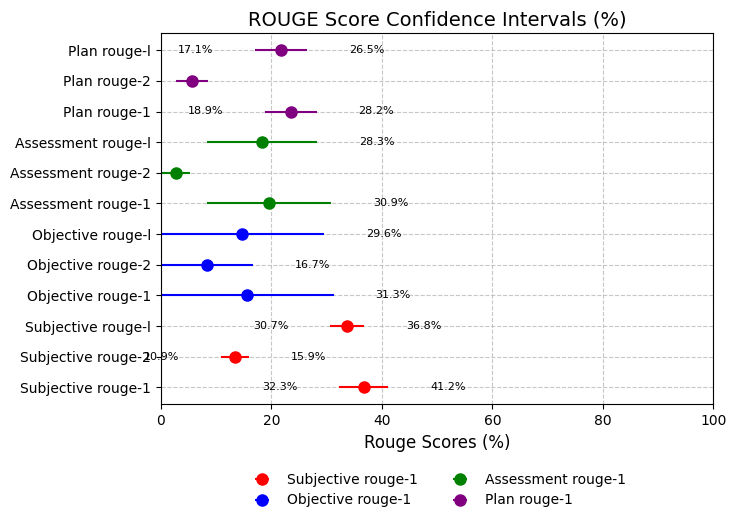

In [22]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors and markers
colors = ['red', 'blue', 'green', 'purple']

# Data format: (metric_name, (lower_bound, upper_bound))
for idx, (section, metrics) in enumerate(ci_results.items()):
    for metric_idx, (metric, bounds) in enumerate(metrics.items()):
        lower = bounds["lower_bound"] * 100  # Convert to percentage
        upper = bounds["upper_bound"] * 100  # Convert to percentage
        x = (lower + upper) / 2
        y = idx * 3 + metric_idx  # Spread out sections and metrics

        ax.errorbar(
            x, y, xerr=[(upper - lower) / 2], fmt='o',
            color=colors[idx], markersize=8,
            label=f"{section} {metric}" if metric_idx == 0 else ""
        )

        # Annotate the plot with lower and upper values if they are >= 10%
        if lower >= 10:
            ax.annotate(f'{lower:.1f}%', (lower, y), textcoords="offset points", xytext=(-30, -2), ha='right', fontsize=8)
        if upper >= 10:
            ax.annotate(f'{upper:.1f}%', (upper, y), textcoords="offset points", xytext=(30, -2), ha='left', fontsize=8)

# Adding details to the chart
ax.set_yticks(range(len(ci_results) * 3))
ax.set_yticklabels([f"{section} {metric}" for section in ci_results for metric in ci_results[section]], fontsize=10)
ax.set_xlabel('Rouge Scores (%)', fontsize=12)
ax.set_title('ROUGE Score Confidence Intervals (%)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Set x-axis limits to percentage
ax.set_xlim(0, 100)

# Adjust the legend placement
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

plt.tight_layout(pad=3)
plt.show()